In [7]:
import torch
import bertviz
from bertviz import model_view
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
import sys
sys.path.append('../') # Dirty hack
from train_transformers import get_base_transformer_lm, get_datasets_and_vocab
from vocabulary import CharVocabulary
from data_utils import build_dataset_addmult_mod10

from evaluate_transformers import package_data


In [9]:
MODEL_LOAD_PATH = '/home/x11kjm/structural-grokking/checkpoints/231117_runs/state_150000.pt'

In [10]:
out_vocab = CharVocabulary(chars=set('0123456789'))
# datasets, in_vocab = get_datasets_and_vocab(, args.lm)

in_vocab = CharVocabulary(chars=set('0123456789+*()='))

vec_dim = 512
n_heads = 4
encoder_n_layers = 2

In [11]:
model, interface = get_base_transformer_lm(in_vocab, vec_dim, n_heads, encoder_n_layers)

In [14]:
data_batch = ['(*(+(+41)(*40))(*7(*(+17)8)))', '(*(*(*(*4(+9(+73)))6)0)4)']
data_tensor = package_data(token_batch)


ValueError: expected sequence of length 29 at dim 1 (got 25)

In [15]:
token_batch

[[0,
  2,
  0,
  3,
  0,
  3,
  8,
  5,
  1,
  0,
  2,
  8,
  4,
  1,
  1,
  0,
  2,
  11,
  0,
  2,
  0,
  3,
  5,
  11,
  1,
  12,
  1,
  1,
  1],
 [0,
  2,
  0,
  2,
  0,
  2,
  0,
  2,
  8,
  0,
  3,
  13,
  0,
  3,
  11,
  7,
  1,
  1,
  1,
  10,
  1,
  4,
  1,
  8,
  1]]

In [101]:
# Parameters for fake data
batch_size = 12  # Number of sequences in a batch
seq_length = 15  # Length of each sequence
feature_size = 512  # Adjusted feature size to match the model's expected input size

# Create a batch of sequences with random floats
# Create src with an adjusted dimension for features
src = torch.rand(batch_size, seq_length, feature_size)

# Create src_len
src_len = torch.randint(5, seq_length + 1, (batch_size,))
attn_matrices = model.trafo.get_attn_matrices(token_batch, src_len)
attn_matrices = tuple(attn_matrices[0].unsqueeze(0).unsqueeze(0))
tokens = [i for i in '0123456789+*()=']

print(f"{src_len = }, {attn_matrices[0].shape = }")
model_view(attn_matrices, tokens)

AttributeError: 'list' object has no attribute 'shape'

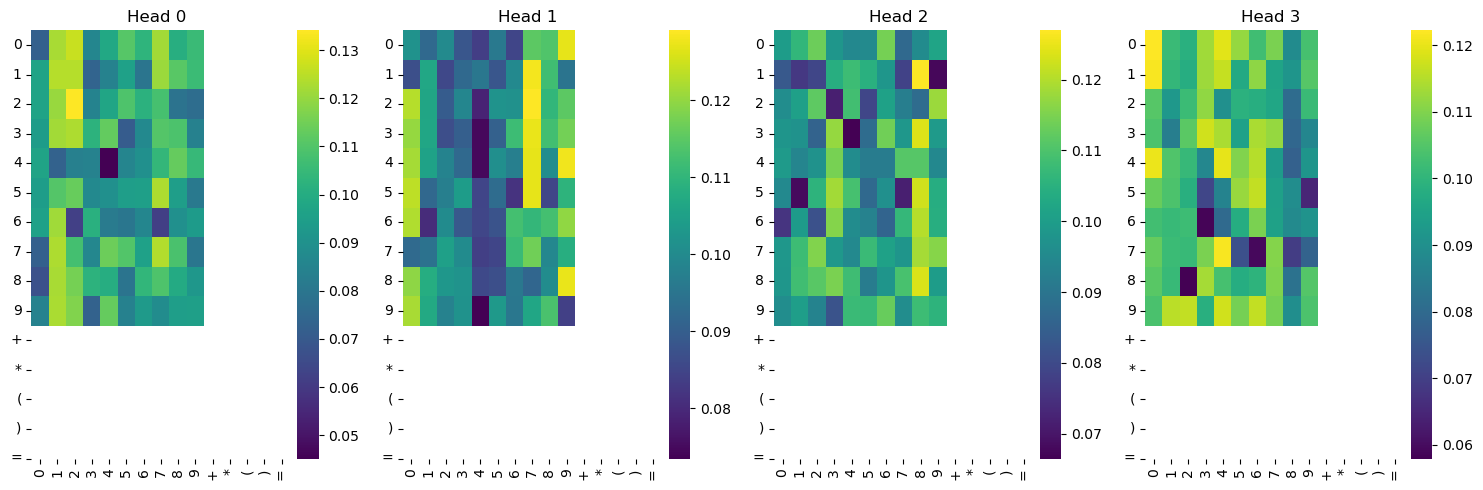

In [65]:
def plot_attention_matrix(attention_matrix, tokens, head=None):
    """
    Plots the attention matrix for the model's heads.
    
    :param attention_matrix: A tensor of shape [num_heads, seq_len, seq_len]
                             representing the attention weights.
    :param tokens: A list of tokens corresponding to the sequence length.
    :param head: Optional; the specific head to visualize. If None, all heads are visualized.
    """
    num_heads = attention_matrix.shape[0]
    seq_len = attention_matrix.shape[1]

    if head is not None:
        heads_to_plot = [head]
    else:
        heads_to_plot = range(num_heads)

    fig, axes = plt.subplots(1, len(heads_to_plot), figsize=(15, 5))

    if len(heads_to_plot) == 1:
        axes = [axes]

    for i, ax in enumerate(axes):
        head_idx = heads_to_plot[i]
        ax.set_title(f'Head {head_idx}')

        # Convert the tensor to a numpy array after detaching it from the computation graph
        attn_data = attention_matrix[head_idx].detach().numpy()
        
        sns.heatmap(attn_data, ax=ax, cmap='viridis', xticklabels=tokens, yticklabels=tokens)
        ax.xaxis.set_tick_params(rotation=90)
        ax.yaxis.set_tick_params(rotation=0)

    plt.tight_layout()
    plt.show()

# Usage example
plot_attention_matrix(attn_matrix, tokens)

ValueError: Must pass 2-d input. shape=(4, 10, 10)

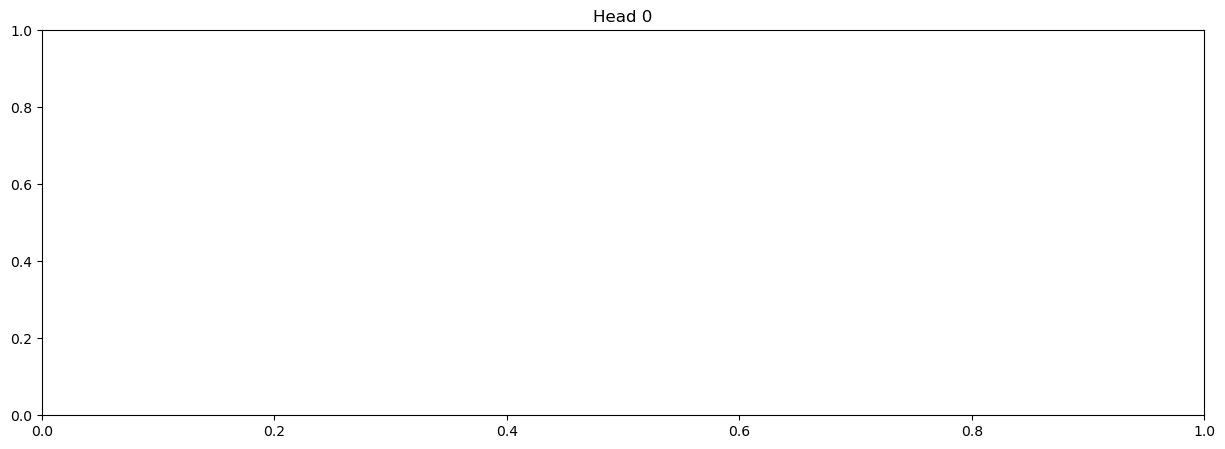

In [57]:
plot_attention_matrix(attn_matrices, tokens)

In [58]:
from transformers import AutoTokenizer, AutoModel, utils
from bertviz import model_view
utils.logging.set_verbosity_error()  # Suppress standard warnings

model_name = "microsoft/xtremedistil-l12-h384-uncased"  # Find popular HuggingFace models here: https://huggingface.co/models
input_text = "The cat sat on the mat"  
model = AutoModel.from_pretrained(model_name, output_attentions=True)  # Configure model to return attention values
tokenizer = AutoTokenizer.from_pretrained(model_name)
inputs = tokenizer.encode(input_text, return_tensors='pt')  # Tokenize input text
outputs = model(inputs)  # Run model
attention = outputs[-1]  # Retrieve attention from model outputs
tokens = tokenizer.convert_ids_to_tokens(inputs[0])  # Convert input ids to token strings
model_view(attention, tokens)  # Display model view

<IPython.core.display.Javascript object>

In [60]:
attention[0].shape

torch.Size([1, 12, 8, 8])

In [24]:
tokens

['[CLS]', 'the', 'cat', 'sat', 'on', 'the', 'mat', '[SEP]']

ValueError: The attention tensor does not have the correct number of dimensions. Make sure you set output_attentions=True when initializing your model.